In [1]:
import os
import numpy as np
import pickle as pkl
import gseapy as gp
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from utils import Volcanoplot, Functional_analysis, gmt_tools
import glob

In [21]:
# Charge the data and filter out non usefull columns
df_counts = pd.read_csv("./Data/counts.tsv",sep="\t",skiprows=1)
df_counts.drop(columns=["Chr","Start","End","Strand","Length"], inplace =True)

# Rename the columns
rename_cols = {i: i.split("/")[-1].split("Alig")[0] for i in df_counts.columns}
df_counts.rename(columns=rename_cols,inplace=True)
df_counts.rename(columns={"sample_1_8522310005559":"sample_16","sample_1_8522310003370":"sample_1"},inplace=True) 

df_counts.head() # Show the dataframe aspect

,Geneid,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_17,sample_1,sample_16,...,sample_23,sample_24,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9
0,ENSG00000279928,0,2,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0,0,0,0
1,ENSG00000228037,19,14,31,2,0,2,2,0,9,...,7,0,1,0,1,3,0,4,5,3
2,ENSG00000142611,18,69,110,6,11,18,20,25,2,...,12,19,27,7,15,8,20,10,24,26
3,ENSG00000284616,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000157911,905,861,832,806,723,1336,839,963,1070,...,676,640,833,1144,955,953,815,829,747,1048


In [22]:
df_counts.columns=df_counts.columns.str.replace("sample_","") 

import json
with open("./Data/dict_samples.json","r") as f:
    samples_d= json.load(f)
    
# Two samples had the label swapped
samples_d["21"]="T3M4_sh1_TNF_4"
samples_d["22"]="T3M4_sh1_4"

# Rename the column to have the condition in the name insead of only anumber
df_counts.rename(columns=samples_d,inplace=True)
df_counts.head()

,Geneid,T3M4_sh1_TNF_2,T3M4_sh2_2,T3M4_sh2_TNF_2,T3M4_SCR_3,T3M4_SCR_TNF_3,T3M4_sh1_3,T3M4_sh2_3,T3M4_SCR_1,T3M4_sh1_TNF_3,...,T3M4_sh2_4,T3M4_sh2_TNF_4,T3M4_SCR_TNF_1,T3M4_sh1_1,T3M4_sh1_TNF_1,T3M4_sh2_1,T3M4_sh2_TNF_1,T3M4_SCR_2,T3M4_SCR_TNF_2,T3M4_sh1_2
0,ENSG00000279928,0,2,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0,0,0,0
1,ENSG00000228037,19,14,31,2,0,2,2,0,9,...,7,0,1,0,1,3,0,4,5,3
2,ENSG00000142611,18,69,110,6,11,18,20,25,2,...,12,19,27,7,15,8,20,10,24,26
3,ENSG00000284616,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000157911,905,861,832,806,723,1336,839,963,1070,...,676,640,833,1144,955,953,815,829,747,1048


In [23]:
df_counts.drop(["T3M4_sh2_2","T3M4_sh2_TNF_2","T3M4_sh1_2",
                "T3M4_sh1_TNF_2","T3M4_sh2_1","T3M4_sh2_TNF_1","T3M4_sh2_3","T3M4_sh2_TNF_3","T3M4_sh2_4","T3M4_sh2_TNF_4"],axis=1,inplace=True) # Remove the outliers

In [24]:
# Anotate the gene_names
with open("./utils/gtf_dict_GRCh38.110.json","r") as f:
    # Charge the anotation dictionary
    gtfdict= json.load(f)

df_counts["gene_name"]=df_counts.Geneid.map(gtfdict)

df_counts= df_counts.iloc[:,[df_counts.shape[1]-1]+[i for i in range(df_counts.shape[1]-1)]].drop("Geneid",axis=1).dropna()
df_counts= df_counts.drop_duplicates(subset="gene_name").set_index("gene_name").T

df_counts.sort_index(inplace=True)

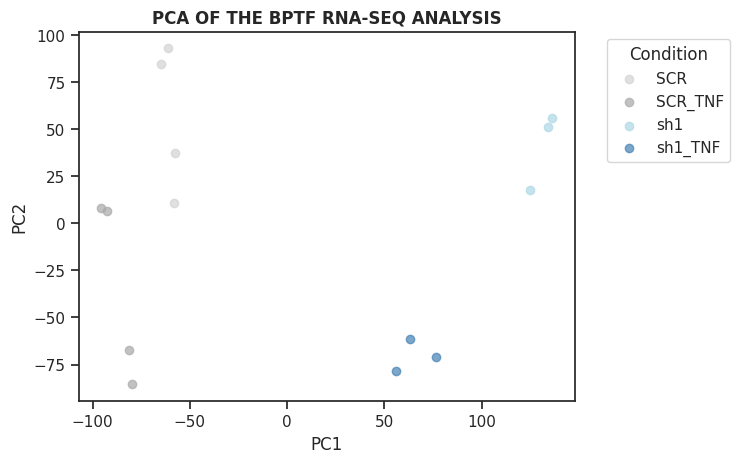

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X= df_counts
X_scaled = StandardScaler().fit_transform(X)

labels = X.index.str.replace("T3M4_","").str.replace("_\d","",regex=True)

samplen= X.index.str.replace(".*_.*_","",regex=True)


pca= PCA(n_components=2).fit_transform(X_scaled)

import seaborn as sns
import matplotlib.pyplot as plt

# for lab,i in enumerate(labels)

palette =  ["lightgray","darkgray","lightblue","steelblue"]

for ind,label in enumerate(labels.unique()):
    
    sub_pca= pca[[i== label for i in labels]]

    plt.scatter(x=sub_pca[:,0],y=sub_pca[:,1],label=label,alpha=0.7,color=palette[ind])
    
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.title("PCA OF THE BPTF RNA-SEQ ANALYSIS",fontweight=800)
plt.ylabel("PC2")
plt.xlabel("PC1")

plt.savefig("./Results/Plots/PCA_plot.png",bbox_inches="tight")
plt.show()

In [26]:
# Filter out the very low expressed genes
print("Genes before filtering: ",df_counts.shape[1])

genes_to_keep = df_counts.columns[df_counts.sum(axis=0) >= 10] # Do not select the lowest expressed genes
df_counts = df_counts[genes_to_keep]

print("Genes after filtering: ",df_counts.shape[1])

Genes before filtering:  40874
Genes after filtering:  21490


In [27]:
# Construct a metadata dataframe
metadata = df_counts.index.to_frame()
metadata["Condition"] = labels
metadata= metadata.drop(0,axis=1)
metadata.head()

,Condition
T3M4_SCR_1,SCR
T3M4_SCR_2,SCR
T3M4_SCR_3,SCR
T3M4_SCR_4,SCR
T3M4_SCR_TNF_1,SCR_TNF


In [28]:
# Save all the normalized counts
dds = DeseqDataSet(
counts=df_counts,
metadata=metadata,
design_factors="Condition",
refit_cooks=True,
n_cpus=30)

dds.deseq2()

# Save the normalized counts

Total_normcounts_df = pd.DataFrame(dds.layers["normed_counts"],
                            columns=df_counts.columns,
                            index=df_counts.index).T

Total_normcounts_df.to_csv(f"./Results/normalizedcounts.csv")

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.83 seconds.

Fitting dispersion trend curve...
... done in 5.12 seconds.

Fitting MAP dispersions...
... done in 1.91 seconds.

Fitting LFCs...
... done in 2.02 seconds.

Refitting 0 outliers.



In [29]:
dfl= []
for gene in ["BPTF","IL1A","IL1B","IL6"]:
    df_plot= Total_normcounts_df.loc[gene].to_frame()
    df_plot["gene"]=gene
    df_plot.rename({gene:"Expression"},axis=1,inplace=True)
    dfl.append(df_plot)
df_plot = pd.concat(dfl)
df_plot["condition"]= df_plot.index.str.replace("_\d","")
df_plot.head()

,Expression,gene,condition
T3M4_SCR_1,5061.764303,BPTF,T3M4_SCR
T3M4_SCR_2,5099.159544,BPTF,T3M4_SCR
T3M4_SCR_3,4954.681456,BPTF,T3M4_SCR
T3M4_SCR_4,5390.010759,BPTF,T3M4_SCR
T3M4_SCR_TNF_1,5104.658184,BPTF,T3M4_SCR_TNF


/tmp/ipykernel_2157/792831062.py:12: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(data=df_plot, x="gene", y="Expression", hue="condition", palette=palette, hue_order=hue_order,


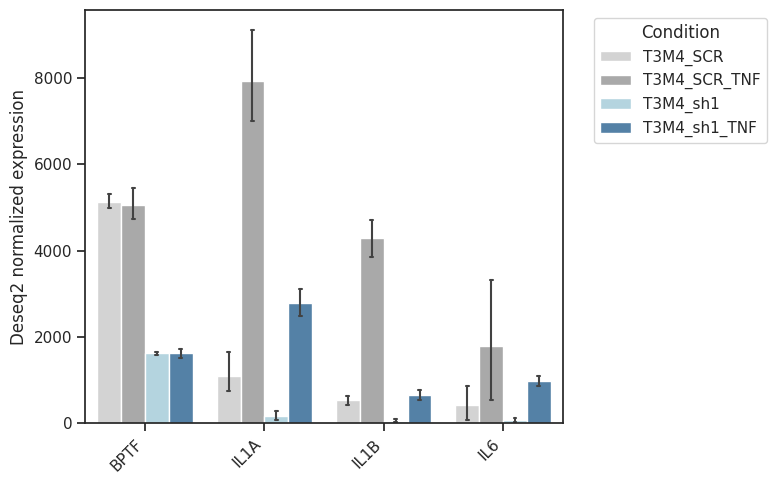

In [31]:
# Crear una paleta de colores
palette =  ["lightgray","darkgray","lightblue","steelblue"]

# Configurar el estilo de Seaborn (puedes ajustar esto según tus preferencias)
sns.set(style="ticks")

# Definir el orden deseado para el hue
hue_order= df_plot.condition.unique()[[0,1,2,3]]

# Crear el gráfico con el orden especificado
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_plot, x="gene", y="Expression", hue="condition", palette=palette, hue_order=hue_order,
                 errwidth=1.5, capsize=0.1)                 

# Añadir título y etiquetas de ejes
#plt.title("Change in gene expression across conditions")
plt.xlabel("")
plt.ylabel("Deseq2 normalized expression",fontsize= 12)

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Añadir leyenda fuera del gráfico para evitar superposiciones
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para mejorar la distribución de elementos
plt.tight_layout()

plt.savefig("./Results/Plots/BPTF_IL1_IL6_expression.png")
# Mostrar el gráfico
plt.show()

# Explore the variation of the enrichment for different signatures with GSVA

In [35]:
# list the signature paths
signatures_path= glob.glob("./Data/Signatures/*.gmt")

for signature in signatures_path:
        # Calculate the gsva
        gsva_res= gp.gsva(data=Total_normcounts_df,gene_sets=signature)
        # Extract the result
        gseva_result = gsva_res.res2d.pivot(index="Name",columns="Term",values="ES").astype(float).T
        # Plot the heatmap
        sns.clustermap(gseva_result,z_score=0,cmap="vlag",metric="euclidean",figsize=(12,6),col_cluster=False,method="median")

        plotname = signature.split("/")[-1].split(".gmt")[0] # Name of the signature
        plt.savefig(f"./Results/Plots/GSVA/GSVA_{plotname}.png") # Save the figure
        plt.close()

# Now I will perform a diferenctial expression analysis for each condition and then save some plots related to these condition tests

In [44]:
def create_results_folder(res_dirname):
    if not os.path.exists(res_dirname):
        os.mkdir(res_dirname)
    else:
        print("Path exists")

In [39]:
contrasts = [['SCR_TNF','SCR'],["sh1_TNF","SCR_TNF"],["sh1","SCR"]]

contrasts_results = {}

for contrast in contrasts:
    contrast_name = "_vs_".join(contrast)
    
    # Subsets the datasets keepeng just the contrast of interest
    sub_metadata = metadata[metadata.Condition.isin(contrast)]
    sub_counts = df_counts.loc[sub_metadata.index]
    
    # sort the dataframes
    sub_metadata.sort_index(inplace=True,ascending=True)
    sub_counts.sort_index(inplace=True,ascending=True)

    if sub_metadata["Condition"][0]!=contrast[0]:
        sub_metadata.sort_index(ascending=False,inplace=True)
        sub_counts.sort_index(ascending=False,inplace=True)
    
    # Initialize the deseq object
    dds = DeseqDataSet(
    counts=sub_counts,
    metadata=sub_metadata,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=30)
    
    dds.deseq2()
    
    # Save the normalized counts
    normcounts_df = pd.DataFrame(dds.layers["normed_counts"],
                             columns=sub_counts.columns,
                             index=sub_counts.index).T
    
    # Perform the differential expression analysis
    stat_res = DeseqStats(dds, n_cpus=30)
    stat_res.contrast = ['Condition'] + contrast
    stat_res.summary()
    result = stat_res.results_df
    
    # Generate the volcano plots
    result = result.reset_index()
    
    # Direrenctial expressed genes
    degs = result.gene_name[(abs(result.log2FoldChange)>1) & (result.padj<0.05)].tolist()

    Volcanoplot.volcano_plot(result,texto=[],path_save=f"./Results/Plots/Volcano_plots/Volcano_plot_{contrast_name}.png",show=False)
    plt.close()
    
    # Direrenctial expressed genes expression matix
    de_normcounts = normcounts_df.T[degs].T

    # Plot the DE heatmap
    sns.clustermap(de_normcounts,z_score=0,cmap="vlag",metric="euclidean",method="median")
    plt.savefig(f"./Results/Plots/Heatmaps/Heatmap_{contrast_name}.png")
    plt.close()


    # Save the results in a dictionary
    
    contrasts_results[contrast_name]= {"Contrast":contrast,
                                       "Normalized_counts": normcounts_df,
                                       "DE_df":result,
                                       "DEGs":degs}
    
    # ======================================================================================

    # Functional analysis

    # GSEA
        
    # Create the cls
    cls_file = Functional_analysis.generate_cls(sub_metadata.Condition,cls_path=f"./Data/cls/{contrast_name}.cls")
    
    # list the signature paths
    signatures_path= glob.glob("./Data/Signatures/Hall*.gmt")
    
    for gene_set in signatures_path: # Iterate the signatures
        # Run the GSEA
        gs_res = gp.gsea(data=sub_counts.T.reset_index(), 
                        gene_sets = gene_set,
                        cls= cls_file, 
                        permutation_type='gene_set',
                        permutation_num=1000,# Just for speed, normaly 1000 
                        outdir=None,  
                        no_plot=True, 
                        method='signal_to_noise',
                        max_size= 50000,
                        min_size=0,
                        format='png', verbose=True)
        
        # Extract the top significative results
        
        result, df_result =  Functional_analysis.sig_finder(gs_res)

        filename  = contrast_name+" "+gene_set.split("/")[-1].split(".")[0]

        if df_result.shape[0]>0:
            # Generate an save the GSEA NES plot and save the report
            Functional_analysis.NES_plot(df_result, outdir="./Results/Plots/GSEA_Hallmarks/", dataset=filename)
            df_result.to_csv(f"./Results/Plots/GSEA_Hallmarks/{filename}_report.csv",index=False)
             
    
with open("./Results/DESEQ_BPTF_RESULTS_dict.pkl","wb") as f:
    pkl.dump(contrasts_results,f)

/tmp/ipykernel_2157/3345371213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.sort_index(ascending=False,inplace=True)
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.68 seconds.

Fitting dispersion trend curve...
... done in 5.36 seconds.

Fitting MAP dispersions...
... done in 1.83 seconds.

Fitting LFCs...
... done in 2.23 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: Condition SCR_TNF vs SCR


... done in 1.97 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
PRDM16,13.284281,0.756990,0.904572,0.836849,0.402677,0.706353
PEX10,783.556211,-0.151467,0.116872,-1.296010,0.194972,0.489042
PEX14,1432.735488,-0.090657,0.079789,-1.136210,0.255868,0.565387
PLCH2,226.043738,0.746485,0.205108,3.639475,0.000273,0.004078
SPSB1,1392.509006,0.430212,0.145383,2.959163,0.003085,0.028414
...,...,...,...,...,...,...
MT-ND4,158586.435286,0.273861,0.237391,1.153628,0.248653,0.557952
MT-ND5,52588.508184,0.079246,0.196151,0.404007,0.686208,0.877153
MT-ND6,3093.786393,0.157036,0.288130,0.545017,0.585742,0.826093


2024-01-05 15:14:23,259 [INFO] Parsing data files for GSEA.............................
2024-01-05 15:14:23,279 [INFO] 0000 gene_sets have been filtered out when max_size=50000 and min_size=0
2024-01-05 15:14:23,283 [INFO] 0050 gene_sets used for further statistical testing.....
2024-01-05 15:14:23,284 [INFO] Start to run GSEA...Might take a while..................


cls file succesfully created in ./Data/cls/SCR_TNF_vs_SCR.cls


2024-01-05 15:14:25,824 [INFO] Congratulations. GSEApy ran successfully.................

/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(
/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: The palette list has more values (44) than needed (33), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_2157/3345371213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.sort_index(ascending=False,inplace=True)
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain under

Log2 fold change & Wald test p-value: Condition sh1_TNF vs SCR_TNF


... done in 1.90 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
PRDM16,13.629444,-0.874052,0.788921,-1.107908,2.679013e-01,0.421886
PEX10,837.560325,0.333602,0.128101,2.604206,9.208746e-03,0.028772
PEX14,1347.186398,-0.154701,0.094589,-1.635509,1.019423e-01,0.202244
PLCH2,377.895195,0.792851,0.161497,4.909396,9.135726e-07,0.000009
SPSB1,1506.951749,-0.261812,0.106630,-2.455333,1.407543e-02,0.040943
...,...,...,...,...,...,...
MT-ND4,176536.389027,0.009400,0.261461,0.035951,9.713214e-01,0.984247
MT-ND5,61033.071830,0.339292,0.207152,1.637888,1.014451e-01,0.201744
MT-ND6,3631.015063,0.295842,0.219841,1.345709,1.783964e-01,0.311506


/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
2024-01-05 15:14:46,448 [INFO] Parsing data files for GSEA.............................
2024-01-05 15:14:46,467 [INFO] 0000 gene_sets have been filtered out when max_size=50000 and min_size=0
2024-01-05 15:14:46,469 [INFO] 0050 gene_sets used for further statistical testing.....
2024-01-05 15:14:46,469 [INFO] Start to run GSEA...Might take a while..................


cls file succesfully created in ./Data/cls/sh1_TNF_vs_SCR_TNF.cls


2024-01-05 15:14:48,996 [INFO] Congratulations. GSEApy ran successfully.................

/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(
/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: The palette list has more values (30) than needed (19), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_2157/3345371213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.sort_index(ascending=False,inplace=True)
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.76 seconds.

Fitting dispersion trend curve...
... done in 

Log2 fold change & Wald test p-value: Condition sh1 vs SCR


... done in 2.01 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
PRDM16,10.095880,-0.073634,0.976679,-0.075392,9.399029e-01,9.638986e-01
PEX10,982.320694,0.392787,0.113310,3.466486,5.273091e-04,1.959966e-03
PEX14,1444.892202,-0.254203,0.087495,-2.905332,3.668635e-03,1.075572e-02
PLCH2,314.150759,1.481999,0.202691,7.311618,2.639443e-13,4.869181e-12
SPSB1,1198.679202,-0.132760,0.146626,-0.905433,3.652358e-01,4.980122e-01
...,...,...,...,...,...,...
MT-ND4,156753.538456,0.129990,0.180295,0.720983,4.709198e-01,5.988499e-01
MT-ND5,59214.124637,0.308576,0.166580,1.852427,6.396448e-02,1.258117e-01
MT-ND6,3464.000843,0.377682,0.250578,1.507240,1.317492e-01,2.267784e-01


/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
2024-01-05 15:15:10,096 [INFO] Parsing data files for GSEA.............................
2024-01-05 15:15:10,116 [INFO] 0000 gene_sets have been filtered out when max_size=50000 and min_size=0
2024-01-05 15:15:10,117 [INFO] 0050 gene_sets used for further statistical testing.....
2024-01-05 15:15:10,117 [INFO] Start to run GSEA...Might take a while..................


cls file succesfully created in ./Data/cls/sh1_vs_SCR.cls


2024-01-05 15:15:12,672 [INFO] Congratulations. GSEApy ran successfully.................

/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(
/home/victor/Documentos/German/TFM_CODE/RNA-Seq/utils/Functional_analysis.py:113: UserWarning: The palette list has more values (30) than needed (19), which may not be intended.
  ax = sns.barplot(


In [70]:
# Save the genes that modify their expression wuen BPTF is inhiblited
BPTF_dep_genes = contrasts_results["sh1_TNF_vs_SCR_TNF"]["DEGs"]
with open(f"Results/bptf_dependant_genes.txt","w") as f:
    f.write(" ".join(BPTF_dep_genes))